# Exploratory Confirmatory Analysis (ECA)

In this notebook, we attempt to derive discriminants for the classification problem described in the EDA notebook. As a reminder, the dataset is avaiable from the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Adult).

We attempt firstly a blind machine learning approach. This can give us a guide as to the complexity of the dataset, i.e. if it is easy to score well or not. It may also help us with the identifying the relevancy of variables - those of which contribute strongly to proper classification. The classifiers we will use are strictly trees implemented in sklearn: trees, forests and gradient boosted trees. We will apply these algorithms to different subset of variables of our dataset, as well as to those selected as noteworthy from the previous EDA.

We then attempt to build our own discriminants manually based on our discoveries in the previous notebook.

## Preliminaries (Imports and function definitions)

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import sklearn.preprocessing as skp
from statsmodels.graphics import mosaicplot
import seaborn as sns

from sklearn import tree

# warn: this import below is needed for successfully importing RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import f1_score

# for jupyter:
import sys
sys.path.append('..')

from classification_funcs.classification_plots import create_dummy_matrix, create_classification_plots, \
    create_quantitative_mekko_charts, create_qualitative_mekko_charts
from salary_eda_jup import data_preparation

%matplotlib notebook

In [2]:
def k_fold_cross_val(Xs, y_var, k=10):
    clf = tree.DecisionTreeClassifier()
    clf_forest = RandomForestClassifier(n_estimators=10)
    clf_boost = HistGradientBoostingClassifier()

    num_folds = k
    N = Xs.shape[0]
    test_size = int(N / num_folds)

    test_idxs = np.random.permutation(N)[:num_folds * test_size].reshape(num_folds, test_size)

    total_score = np.asarray([0., 0., 0.])
    total_F1_score = np.asarray([0., 0., 0.])

    for i in range(num_folds):
        print("Iteration " + str(i) + ":")
        test_i = Xs.index.isin(test_idxs[i])
        df_train, df_test = Xs[~test_i], Xs[test_i]
        y_train, y_test = y_var[~test_i], y_var[test_i]

        clf = clf.fit(df_train.to_numpy(), y_train.to_numpy().ravel())
        score_b = clf.score(df_test.to_numpy(), y_test.to_numpy().ravel())

        clf_forest = clf_forest.fit(df_train.to_numpy(), y_train.to_numpy().ravel())
        score_f = clf_forest.score(df_test.to_numpy(), y_test.to_numpy().ravel())

        clf_boost = clf_boost.fit(df_train.to_numpy(), y_train.to_numpy().ravel())
        score_h = clf_boost.score(df_test.to_numpy(), y_test.to_numpy().ravel())

        y_hat = clf.predict(df_test.to_numpy())
        f1_b = f1_score(y_test.to_numpy().ravel(), y_hat, average='binary')
        print("F1 score (tree):", f1_b)
    
        y_hat = clf_forest.predict(df_test.to_numpy())
        f1_f = f1_score(y_test.to_numpy().ravel(), y_hat, average='binary')
        print("F1 score (forest):", f1_f)

        y_hat = clf_boost.predict(df_test.to_numpy())
        f1_boost = f1_score(y_test.to_numpy().ravel(), y_hat, average='binary')
        print("F1 score (boost):", f1_boost)

        print("Prediction scores for (tree,forest,boost):", score_b, score_f, score_h)
        total_score += np.asarray([score_b, score_f, score_h])
        total_F1_score += np.asarray([f1_b, f1_f, f1_boost])


    print("Avg. accuracy scores for (tree,forest,boost):", total_score / num_folds)
    print("Avg. F1 scores for (tree,forest,boost):", total_F1_score / num_folds)

    
    return clf,clf_forest, clf_boost


def plot_biplot_w_class(bi_df: pd.DataFrame, idx_class_true, class_labels, colors=None):
    if colors is None:
        colors = [None, None]

    LN = np.sum(idx_class_true)
    MN = len(y_variable) - LN

    cols = bi_df.columns
    jitter_size = 0.01

    bi_df = bi_df.to_numpy()

    fig, ax = plt.subplots(1)

    ax.scatter(bi_df[idx_class_true, 0] + np.random.normal(0, jitter_size, LN),
               bi_df[idx_class_true, 1], label=class_labels[0],
               marker='x', alpha=0.7, color=colors[0])
    ax.scatter(bi_df[~idx_class_true, 0] + np.random.normal(0, jitter_size, MN),
               bi_df[~idx_class_true, 1],
               label=class_labels[1], alpha=0.9, color=colors[1])
    ax.set_xlabel(cols[0])
    ax.set_ylabel(cols[1])
    plt.legend()

## Start of Analysis

In [31]:
df = data_preparation('adult.csv')

df_qual = df.select_dtypes(exclude=np.number)
df_quant = df.select_dtypes(include=np.number)
df_dummies = create_dummy_matrix(df_qual, )

# change 'Salary' to dummy variable (less than 50K).
y_variable = pd.get_dummies(df['Salary'], prefix='Salary', prefix_sep=': ')['Salary: <=50K']

['<=50K' '>50K']


## Automatic construction of trees via machine learning

### Trees with quantitative variables

We begin first by selecting only quantative variables for our dataset, and seeing how well they perform with respect to three different machine learning algorithms: trees, forests and boosted trees.

In [4]:
_ = k_fold_cross_val(df_quant,y_variable,10)

Iteration 0:
F1 score (tree): 0.8333333333333333
F1 score (forest): 0.8509729473184623
F1 score (boost): 0.8971046770601336
Prediction scores for (tree,forest,boost): 0.752936988252047 0.7764328942684229 0.8355286578853685
Iteration 1:
F1 score (tree): 0.8378967773200873
F1 score (forest): 0.8525456292026896
F1 score (boost): 0.8918181818181817
Prediction scores for (tree,forest,boost): 0.7595255212077642 0.7792954708842559 0.8289000718907261
Iteration 2:
F1 score (tree): 0.8452830188679246
F1 score (forest): 0.8641114982578398
F1 score (boost): 0.8961700243524463
Prediction scores for (tree,forest,boost): 0.7676230959971662 0.7927736450584485 0.8338646829613886
Iteration 3:
F1 score (tree): 0.8355041003376747
F1 score (forest): 0.8634965696711615
F1 score (boost): 0.9020490880432335
Prediction scores for (tree,forest,boost): 0.7534345625451916 0.7913955169920462 0.8427331887201736
Iteration 4:
F1 score (tree): 0.8434782608695652
F1 score (forest): 0.8644671255637313
F1 score (boost): 

Depending on the technique, the accuracy was around 75 to 85 percent with the average scores not deviating far from the score of each iteration.

### Trees with qualitative variables

Here we look at only the qualitative variables, we find that naive decision trees and forests perform better with this subset of the data:

In [5]:
df_dummy_qual = create_dummy_matrix(df_qual.drop(columns=['Salary']),)
df_dummy_qual = df_dummy_qual.convert_dtypes(convert_integer=True) # warn: needed to avoid error in this notebook
_ = k_fold_cross_val(df_dummy_qual, y_variable, 10)

Iteration 0:
F1 score (tree): 0.8733910601450972
F1 score (forest): 0.8861168861168861
F1 score (boost): 0.8919908466819222
Prediction scores for (tree,forest,boost): 0.8059540889526542 0.823170731707317 0.830703012912482
Iteration 1:
F1 score (tree): 0.8790601243953007
F1 score (forest): 0.887462754985102
F1 score (boost): 0.8919529837251357
Prediction scores for (tree,forest,boost): 0.8135653409090909 0.8256392045454546 0.8302556818181818
Iteration 2:
F1 score (tree): 0.8847775175644027
F1 score (forest): 0.8898167478543262
F1 score (boost): 0.8962826984855439
Prediction scores for (tree,forest,boost): 0.8240972470504112 0.8301751877011083 0.838398283875581
Iteration 3:
F1 score (tree): 0.870148538572113
F1 score (forest): 0.8778643987715568
F1 score (boost): 0.8896164639850327
Prediction scores for (tree,forest,boost): 0.8044027426921689 0.8134247564056297 0.8296643810898593
Iteration 4:
F1 score (tree): 0.8701854493580599
F1 score (forest): 0.881204422488826
F1 score (boost): 0.883

### Tress with all variables

When using all variables, we do not find much improvements in trees and forests, but a decent increase for the boosted trees over our last two sets of results. However, perhaps  utilizing all variables is wasteful.

In [6]:
_ = k_fold_cross_val(pd.concat((df_dummy_qual,df_quant),axis=1),y_variable,10)

Iteration 0:
F1 score (tree): 0.8754414881092536
F1 score (forest): 0.8985507246376812
F1 score (boost): 0.9170105456212746
Prediction scores for (tree,forest,boost): 0.8130081300813008 0.8465889006716154 0.872039589961117
Iteration 1:
F1 score (tree): 0.8692476260043829
F1 score (forest): 0.8844466114090687
F1 score (boost): 0.913662239089184
Prediction scores for (tree,forest,boost): 0.8066258552394671 0.8293122074180771 0.8689232985235866
Iteration 2:
F1 score (tree): 0.8707772265532718
F1 score (forest): 0.8919745822546482
F1 score (boost): 0.9141680018310827
Prediction scores for (tree,forest,boost): 0.8049215406562055 0.8363052781740371 0.8662624821683309
Iteration 3:
F1 score (tree): 0.8761904761904763
F1 score (forest): 0.8965190622780014
F1 score (boost): 0.9169942196531793
Prediction scores for (tree,forest,boost): 0.8131512756018685 0.8429752066115702 0.87100251527129
Iteration 4:
F1 score (tree): 0.8752683043167184
F1 score (forest): 0.8974662562159602
F1 score (boost): 0.9

### Trees using only selected variables from earlier EDA

If we only use the variables we highlighted as showing strong distinctions for the (> 50k) class, we find that our results improve for all algorithms:

In [32]:
df2 = df[['Capital-gain', 'Capital-loss', 'Education', 'Relationship','Occupation']]
df2_dummies = create_dummy_matrix(df2, )
clf,clf_forest, clf_boost = k_fold_cross_val(df2_dummies,y_variable,10)

Iteration 0:
F1 score (tree): 0.904903078677309
F1 score (forest): 0.9023722627737226
F1 score (boost): 0.9088822584347028
Prediction scores for (tree,forest,boost): 0.8509649749821301 0.8470335954253038 0.8581129378127234
Iteration 1:
F1 score (tree): 0.904496986555401
F1 score (forest): 0.9070786257781878
F1 score (boost): 0.9069389649570665
Prediction scores for (tree,forest,boost): 0.8520646319569121 0.8552962298025135 0.8560143626570915
Iteration 2:
F1 score (tree): 0.9087574507106833
F1 score (forest): 0.9088007295941632
F1 score (boost): 0.9134505594884678
Prediction scores for (tree,forest,boost): 0.8568860122258181 0.8561668464581086 0.863718087019058
Iteration 3:
F1 score (tree): 0.9079219288174513
F1 score (forest): 0.9067524115755627
F1 score (boost): 0.9115677672592936
Prediction scores for (tree,forest,boost): 0.8561692969870875 0.8543758967001435 0.8626255380200861
Iteration 4:
F1 score (tree): 0.9058152793614596
F1 score (forest): 0.9068181818181817
F1 score (boost): 0.

We now have consistency  between the different algorithms in accuracy and F1 score. These variables (for any of the m.l. algorithm) seem to do as well as the boosted algorithm on all the variables. We plot below the basic decision tree (non-boosted or forest):

<IPython.core.display.Javascript object>


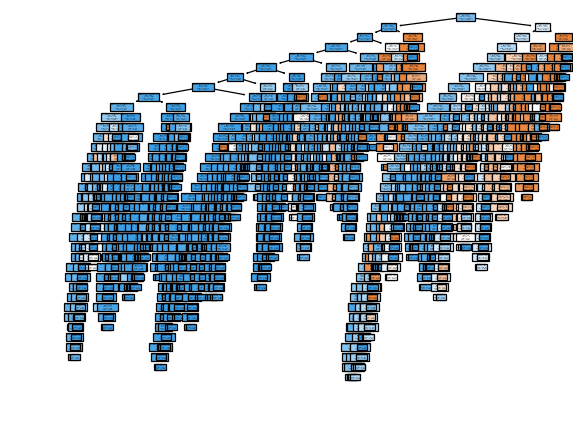

In [8]:
fig, ax = plt.subplots(1)

_ = tree.plot_tree(clf,feature_names=df2_dummies.columns,class_names=['> 50k','<=50k'],
                   filled=True,proportion=False,ax=ax)
plt.show()

Even for just 5 variables, the tree looks unwieldly. Perhaps it is prunable without losing much accuracy.

We next proceed to designing a decision tree from scratch by hand.

## Manual construction of a decision tree

### Finding a discriminant via the Capital-gain variable

We will begin discriminating via the Capital-gain variable, of which will lead us to removing a selection of the data. In doing so, we will have to re-plot the remaining data to see how the distribution of the classes change with respect to each variable. 

Due to there being significantly less (> 50k) individuals than (<= 50k) individuals, perhaps it would be beneficial to find situations that would help us identify precisely when an individual earns > 50k, more so than finding those that help us identify those earning <= 50k. 

Before proceeding let us note keep track of the number of points in our classes:

In [9]:
o_y_variable = y_variable.copy() # Needed later, as we will update the y_variable.

total_individuals = len(y_variable)
num_less = np.sum(y_variable)
num_more = len(y_variable) - num_less
print("N:",total_individuals)
print("num of <=50k:", num_less)
print("num of >50k:", num_more)
print("ratio:", num_more/ num_less)
y_pred = np.ones_like(y_variable)
print("F1 score of naive classifer:",f1_score(y_pred,y_variable,))
print("Accuracy of naive classifer:",num_less / total_individuals)

N: 30162
num of <=50k: 22654
num of >50k: 7508
ratio: 0.3314204996910038
F1 score of naive classifer: 0.8578461072402302
Accuracy of naive classifer: 0.7510775147536636


The statistics above suggests that if we design a *naive classifier* that returns (<=50K) for any input, we obtain an accuracy of 22654/30162, which is 75%, with an F1 score of 85%.

This implies that the the decision tree algorithm applied to only quantative variables did not present an average prediction score much different from this naive classifier.

Let us plot the variable Capital-gain against Age (as an arbitrary choice):

<IPython.core.display.Javascript object>


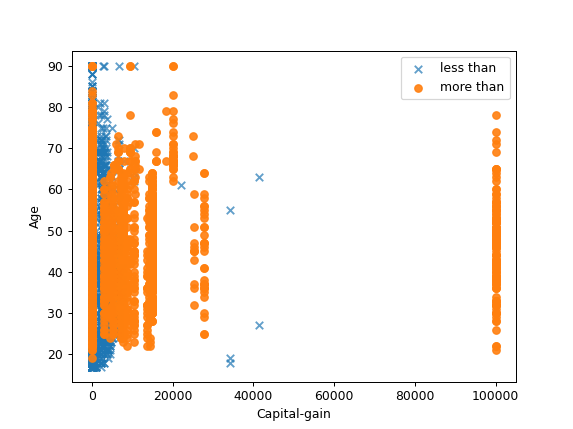

In [10]:
less_than_index = y_variable == 1
plot_biplot_w_class(df_quant[['Capital-gain', 'Age']], less_than_index,
                    ['less than', 'more than'])

plt.show()

Studying this variable, we find a good discriminant at the horizontal line (Capital-gain > 7000). This discriminates the data as follows:

<IPython.core.display.Javascript object>


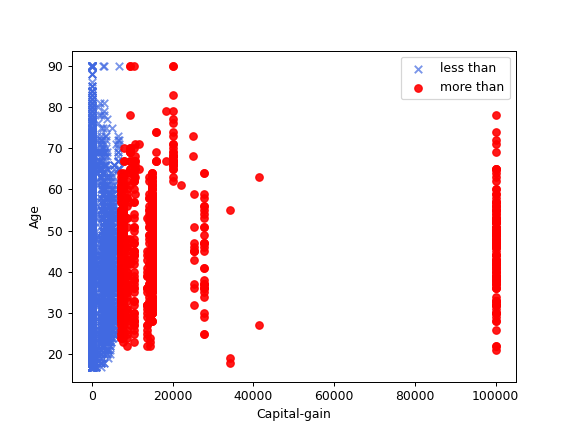

Number of points classified as >=50k:  1330
Miss-classifications: 18
True classification percent: 0.9864661654135338
Potential F1 score of naive classifer + Capital-gain discriminant: 0.8793069960766033
Potential accuracy of naive classifer + Capital-gain discriminant: 0.7945759565015582


In [11]:
# substep: Remove points of 'more than' that are easy to discriminate,
#  where Capital-gain is more than 0.6 (and the points are strictly > 50K)
clust1_idx = df_quant['Capital-gain'] > 7000
clust2_idx = ~clust1_idx

plot_biplot_w_class(df_quant[['Capital-gain', 'Age']], clust2_idx,
                    ['less than', 'more than'], ['royalblue', 'red'])
plt.show()

outlyings = clust1_idx.sum()
print("Number of points classified as >=50k: ", outlyings)
misclass = y_variable[clust1_idx].sum()
print("Miss-classifications:", misclass)
print("True classification percent:", (outlyings - misclass) / outlyings)

y_pred[clust1_idx] = 0
print("Potential F1 score of naive classifer + Capital-gain discriminant:",f1_score(y_pred,y_variable,))
print("Potential accuracy of naive classifer + Capital-gain discriminant:",(num_less+outlyings-misclass) / total_individuals)

Out of the 7500 or so points of class (>50k), we have found a way to classify around 1330 of them with only a few mis-classifications. In this case, if we append this discriminant to our naive classifier - to first discriminate via Capital-gain as above, then assume the rest are <=50k, we get an accuracy score of around (22654 + 1330 - 18)/ 30162 = 79.5%, with an F1 of to 87%.

Let us move on to our next variable: Capital-loss.

### Finding a discriminant via the Capital-loss variable

In [12]:
tree_clust2_idx = clust2_idx
tree_clust1_idx = clust1_idx
o_df = df.copy()
prev_total_outlyings = outlyings
prev_total_misclass = misclass

# first remove all points previously classified as > 50k:
df = df[clust2_idx]
df_qual = df.select_dtypes(exclude=np.number)
df_quant = df.select_dtypes(include=np.number)
df_dummies = create_dummy_matrix(df_qual, )
y_variable = pd.get_dummies(df['Salary'], prefix='Salary', prefix_sep=': ')['Salary: <=50K']
df_qual_wo_sal = df_qual.drop(columns=['Salary'])
less_than_index = y_variable == 1

We study the relationship with variables again, after removing the previously classified points.

<IPython.core.display.Javascript object>


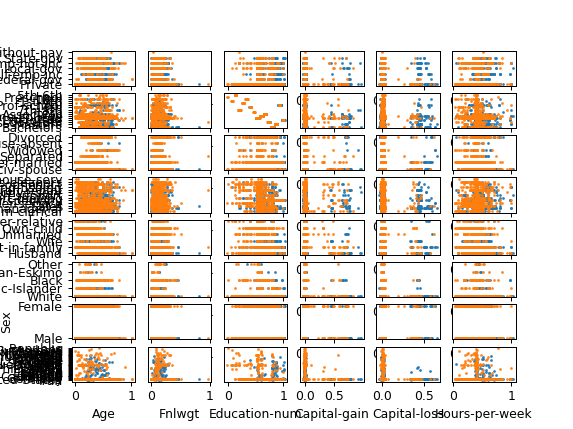

<IPython.core.display.Javascript object>


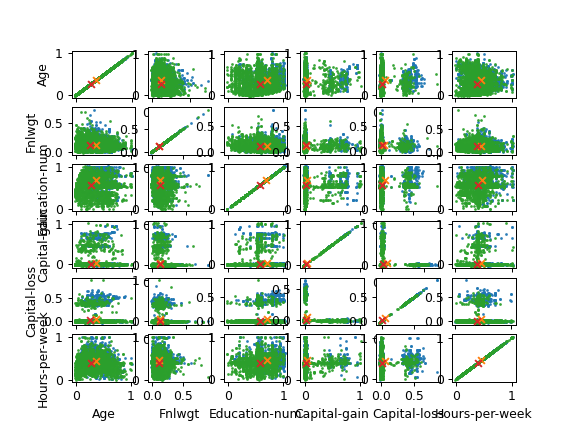

In [13]:
create_quantitative_mekko_charts(df_quant.copy(), df_qual_wo_sal.copy(), y_variable, 
                                 num_samples=1000,jitter=True,hide_legend=True)
create_classification_plots(df_quant.copy(), y_variable, jitter=True, num_samples=5000,
                            jitter_size=0.01,hide_legend=True)
plt.show()

The plots above were introduced in the EDA notebook. They suggest studying Capital-loss relative to: Education, Hours-per-week, and Native-country. Let us evaluate the case with Education first.

### Capital-Loss vs Education

<IPython.core.display.Javascript object>


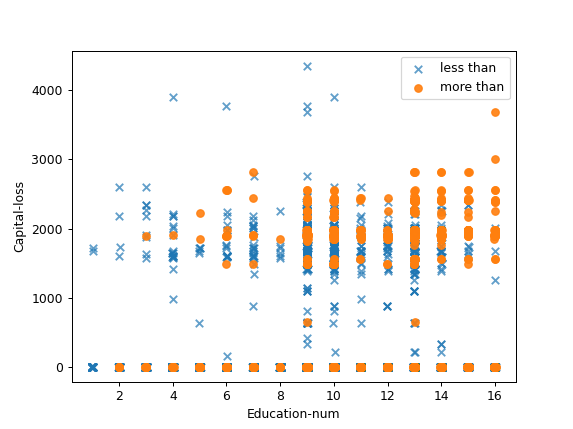

In [14]:
plot_biplot_w_class(df_quant[['Education-num', 'Capital-loss']], less_than_index,
                    ['less than', 'more than'])
plt.show()

<IPython.core.display.Javascript object>


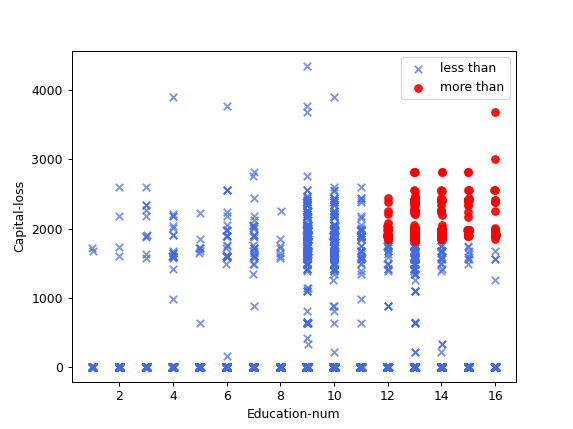

Number of points classified as >=50k:  485
Miss-classifications: 64
True classification percent: 0.8680412371134021
Potential F1 score of (naive classifer + Capital-gain + Capital-loss): 0.8851591145271661
Potential accuracy of (naive classifer + Capital-gain + Capital-loss): 0.8085339168490153


In [15]:
# substep: cluster as (> 1800) for Capital-Loss, (>= 12) (or 13) for Education-num
clust1_idx = (df_quant['Education-num'] >= 12) & (df_quant['Capital-loss'] >= 1800)
clust2_idx = ~clust1_idx

plot_biplot_w_class(df_quant[['Education-num', 'Capital-loss']], clust2_idx,
                    ['less than', 'more than'], ['royalblue', 'red'])
plt.show()

outlyings = clust1_idx.sum()
print("Number of points classified as >=50k: ", outlyings)
misclass = y_variable[clust1_idx].sum()
print("Miss-classifications:", misclass)
print("True classification percent:", (outlyings - misclass) / outlyings)

tree_clust1_idx |= (o_df['Education-num'] >= 12) & (o_df['Capital-loss'] >= 1800)
y_pred[tree_clust1_idx] = 0
print("Potential F1 score of (naive classifer + Capital-gain + Capital-loss):", f1_score(y_pred, o_y_variable))
print("Potential accuracy of (naive classifer + Capital-gain + Capital-loss):",
      (num_less + outlyings - misclass + prev_total_outlyings - prev_total_misclass) / total_individuals)

Using the discriminant above, we obtain an overall accuracy of (22654 + 1330 - 18 + 485 - 64)/ 30162, or 80.1%.

### Capital-Loss vs  Others

We plot also other co-variables we could have used instead of Education-num below. We find that none are that useful:

<IPython.core.display.Javascript object>


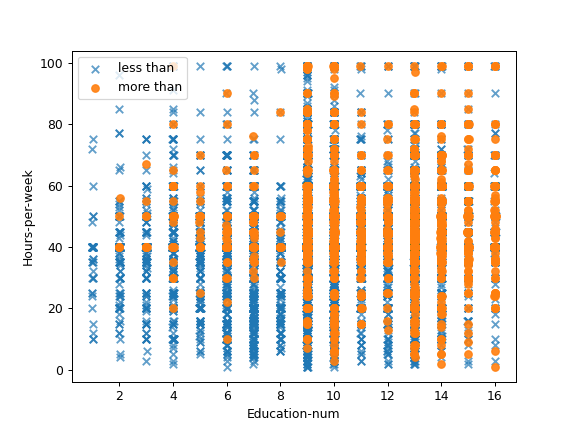

<IPython.core.display.Javascript object>


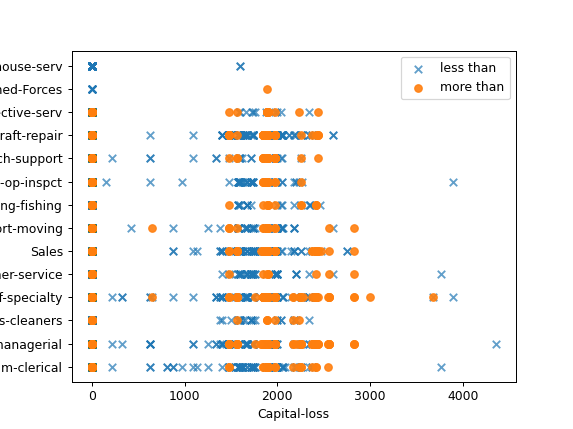

<IPython.core.display.Javascript object>


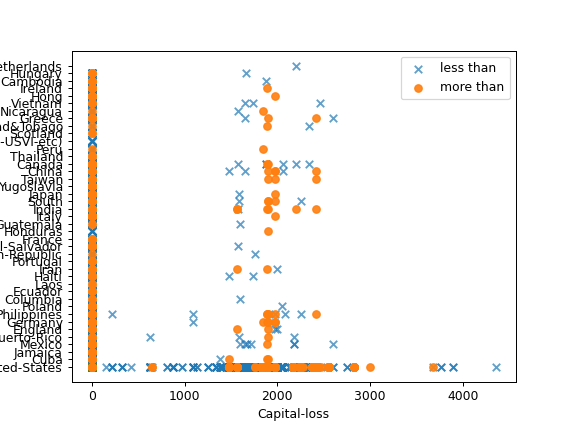

In [16]:
plot_biplot_w_class(df_quant[['Education-num', 'Hours-per-week']], less_than_index,
                    ['less than', 'more than'])
plot_biplot_w_class(pd.concat((df_quant['Capital-loss'], df_qual['Occupation']), axis=1), less_than_index,
                    ['less than', 'more than'])
plot_biplot_w_class(pd.concat((df_quant['Capital-loss'], df_qual['Native-country']), axis=1), less_than_index,
                    ['less than', 'more than'])
plt.show()

### Finding discriminants via: Education, Relationship and Occupation

In [17]:
prev_total_outlyings += outlyings
prev_total_misclass += misclass

# substep: remove discriminated points
df = df[clust2_idx]
df_qual = df.select_dtypes(exclude=np.number)
df_quant = df.select_dtypes(include=np.number)
df_dummies = create_dummy_matrix(df_qual)
y_variable = pd.get_dummies(df['Salary'], prefix='Salary', prefix_sep=': ')['Salary: <=50K']
df_qual_wo_sal = df_qual.drop(columns=['Salary'])
less_than_index = y_variable == 1

<IPython.core.display.Javascript object>


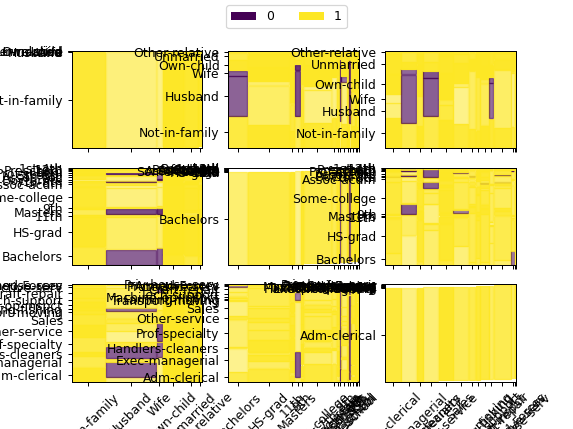

In [18]:
create_qualitative_mekko_charts(x_qual=df_qual[['Relationship', 'Education', 'Occupation']], y_var=y_variable,
                                share_y=False)
plt.show()

Let us see if we can find a discriminant for the (> 50k) class via Relationship,Occupation and Eduation. The first two we will inspect are:
1. Relationship (Wife,Husband) and Occupation (Doctorate, Prof-school, Masters) 
2. Relationship (Husband, Wife) and Occupation (Exec-managerial, Prof-speciality)

The remainder will be adaptations or combinations of these categories.

### 1. Relationship (Wife,Husband) and Occupation (Doctorate, Prof-school, Masters) 

In [19]:
clust1_idx = (df_qual['Relationship'].isin(['Wife', 'Husband'])) & (
    df_qual['Education'].isin(['Doctorate', 'Prof-school', ]))

clust2_idx = ~clust1_idx

outlyings = clust1_idx.sum()
print("Number of points classified as >=50k: ", outlyings)
misclass = y_variable[clust1_idx].sum()
print("Miss-classifications:", misclass)
print("True classifcation percent:", (outlyings - misclass) / outlyings)

tree_clust1_idx_pot = (o_df['Relationship'].isin(['Wife', 'Husband'])) & (
    o_df['Education'].isin(['Doctorate', 'Prof-school', ]))

y_pred_pot = y_pred.copy()
y_pred_pot[tree_clust1_idx | tree_clust1_idx_pot] = 0
print("Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...):", f1_score(y_pred_pot, o_y_variable, ))
print("Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...):",
      (num_less + outlyings - misclass + prev_total_outlyings - prev_total_misclass) / total_individuals)

Number of points classified as >=50k:  408
Miss-classifications: 94
True classifcation percent: 0.7696078431372549
Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...): 0.8885814243077107
Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...): 0.8189443670844109


If we, add this to the set of discriminants above and the naive classifer at the start, we have an accuracy score of:

### 2. Relationship (Wife) and Occupation (Doctorate, Prof-school, Masters) 

In [20]:
clust1_idx = (df_qual['Relationship'].isin(['Wife', ])) & (
    df_qual['Education'].isin(['Doctorate', 'Prof-school', ]))

clust2_idx = ~clust1_idx

outlyings = clust1_idx.sum()
print("Number of points classified as >=50k: ", outlyings)
misclass = y_variable[clust1_idx].sum()
print("Miss-classifications:", misclass)
print("True classifcation percent:", (outlyings - misclass) / outlyings)

tree_clust1_idx_pot = (o_df['Relationship'].isin(['Wife', ])) & (
    o_df['Education'].isin(['Doctorate', 'Prof-school', ]))

y_pred_pot = y_pred.copy()
y_pred_pot[tree_clust1_idx | tree_clust1_idx_pot] = 0
print("Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...):",
      f1_score(y_pred_pot, o_y_variable, ))
print("Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...):",
      (num_less + outlyings - misclass + prev_total_outlyings - prev_total_misclass) / total_individuals)

Number of points classified as >=50k:  23
Miss-classifications: 5
True classifcation percent: 0.782608695652174
Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...): 0.885362313154694
Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...): 0.8091306942510443


### 3. Relationship (Husband, Wife) and Occupation (Exec-managerial, Prof-speciality)

In [21]:
clust1_idx = (df_qual['Relationship'].isin(['Wife', 'Husband'])) & (
    df_qual['Occupation'].isin(['Prof-specialty', 'Exec-managerial', ]))

clust2_idx = ~clust1_idx

outlyings = clust1_idx.sum()
print("Number of points classified as >=50k: ", outlyings)
misclass = y_variable[clust1_idx].sum()
print("Miss-classifications:", misclass)
print("True classifcation percent:", (outlyings - misclass) / outlyings)

tree_clust1_idx_pot = (o_df['Relationship'].isin(['Wife', 'Husband'])) & (
        o_df['Occupation'].isin(['Prof-specialty', 'Exec-managerial', ]))

y_pred_pot = y_pred.copy()
y_pred_pot[tree_clust1_idx | tree_clust1_idx_pot] = 0
print("Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...):",
      f1_score(y_pred_pot, o_y_variable, ))
print("Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...):",
      (num_less + outlyings - misclass + prev_total_outlyings - prev_total_misclass) / total_individuals)

Number of points classified as >=50k:  3535
Miss-classifications: 1325
True classifcation percent: 0.6251768033946252
Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...): 0.8952513377996882
Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...): 0.8818049200981367


### 4. Relationship (Wife) and Occupation (Prof-speciality)

In [22]:
clust1_idx = (df_qual['Relationship'].isin(['Wife', ])) & (
    df_qual['Occupation'].isin(['Prof-specialty', ]))

clust2_idx = ~clust1_idx

outlyings = clust1_idx.sum()
print("Number of points classified as >=50k: ", outlyings)
misclass = y_variable[clust1_idx].sum()
print("Miss-classifications:", misclass)
print("True classifcation percent:", (outlyings - misclass) / outlyings)

tree_clust1_idx_pot = (o_df['Relationship'].isin(['Wife', ])) & (
    o_df['Occupation'].isin(['Prof-specialty', ]))

y_pred_pot = y_pred.copy()
y_pred_pot[tree_clust1_idx | tree_clust1_idx_pot] = 0
print("Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...):",
      f1_score(y_pred_pot, o_y_variable))
print("Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...):",
      (num_less + outlyings - misclass + prev_total_outlyings - prev_total_misclass) / total_individuals)

Number of points classified as >=50k:  236
Miss-classifications: 76
True classifcation percent: 0.6779661016949152
Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...): 0.8862799172658328
Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...): 0.8138386048670513


### 5. 3D: Relationship (Wife,Husband) & Occupation (Prof-Speciality, Exec-Managerial)  & Education (Doctorate, Prof-School,Masters)

In [23]:
clust1_idx = (df_qual['Relationship'].isin(['Wife', 'Husband'])) & (
    df_qual['Occupation'].isin(['Prof-specialty', 'Exec-Managerial'])
    & df_qual['Education'].isin(['Doctorate', 'Prof-school', 'Masters']))


clust2_idx = ~clust1_idx

outlyings = clust1_idx.sum()
print("Number of points classified as >=50k: ", outlyings)
misclass = y_variable[clust1_idx].sum()
print("Miss-classifications:", misclass)
print("True classifcation percent:", (outlyings - misclass) / outlyings)

tree_clust1_idx_pot = (df_qual['Relationship'].isin(['Wife', 'Husband'])) & (
    df_qual['Occupation'].isin(['Prof-specialty', 'Exec-Managerial'])
    & df_qual['Education'].isin(['Doctorate', 'Prof-school', 'Masters', ]))

y_pred_pot = y_pred.copy()
y_pred_pot[tree_clust1_idx | tree_clust1_idx_pot] = 0
print("Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...):",
      f1_score(y_pred_pot, o_y_variable))
print("Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...):",
      (num_less + outlyings - misclass + prev_total_outlyings - prev_total_misclass) / total_individuals)

Number of points classified as >=50k:  659
Miss-classifications: 162
True classifcation percent: 0.7541729893778453
Potential F1 score of (naive classifer + Capital-gain + Capital-loss + ...): 0.8903102777005284
Potential accuracy of (naive classifer + Capital-gain + Capital-loss + ...): 0.8250116040050395


Thus, it would appear that the third study above [Relationship (Husband, Wife) and Occupation (Exec-managerial, Prof-speciality)] provides the best accuracy and F1 score.

## Summary and Future work

We found thus far that the variables selected from the EDA procedure lead to the best accuracy and F1 score combination during the machine learning procedure. When manually constructing a model, we found that we could attain accuracy reasonably close to the machine learning algorithms via the following decision rule:

In [34]:
def more_than_50k(x: pd.DataFrame):
    boolean_mask_more_than = (x['Capital-gain'] > 7000) \
                             | ((x['Capital-loss'] >= 1800) & (x['Education-num'] >= 12)) \
                             | ((x['Relationship'].isin(['Wife', 'Husband'])) &
                                (x['Occupation'].isin(['Prof-specialty', 'Exec-managerial'])))
    boolean_mask_less_than = np.logical_not(boolean_mask_more_than.to_numpy())
    binary_mask = boolean_mask_less_than.astype(int)

    return binary_mask

The decision rule has an F1 score of 0.8952513377996882, and an accuracy of 0.8818049200981367. The boosted tree algorithm on the selected variables from EDA yielded a F1 Score of roughyl 0.91 and an accuracy of 0.86%, an average of the cross-validated results.

Our function above compared to the decision tree previously plotted is much simpler. We are inclined to believe that the plotted decision-tree above is overfitting and require pruning before being utilized, hence we prefer our model for deployment relative to the basic tree algorithm. 

As for future work, we found it difficult to plot the bi-mosaic plots (or qualitative mekko plots) without having the labels overlap each other. An alternative may be to use mosaic plots of equal sized tiles, i.e. heatmaps, where the original size of a tile now plays a role in defining the color of the tile further - thus  each tile is also a function of the frequency of occurence of a particular pair of categories of two variables.

With regards to the machine learning approach, we could attempt to reduce the number of variables further by doing a brute force search with the selected EDA variables, and also limit the maximum depth of trees. Both may yield better models.

## Test set scoring

A held out set is available to test the scores. Let us see what accuracy we can obtain with the machine learning tree algorithms, and our manual tree algorithm:

In [33]:
df_test = data_preparation('adult.test')
df2_test = df_test[['Capital-gain', 'Capital-loss', 'Education', 'Relationship','Occupation']]
df2_test_dummies = create_dummy_matrix(df2_test, )

y_test_variable = pd.get_dummies(df_test['Salary'], prefix='Salary', prefix_sep=': ')['Salary: <=50K']

scores = [tree_i.score(df2_test_dummies.to_numpy(), y_test_variable.to_numpy().ravel()) for tree_i in trees]
predicts = [tree_i.predict(df2_test_dummies.to_numpy()) for tree_i in trees]
f1s = [f1_score(y_test_variable.to_numpy().ravel(), predicts[i], average='binary') for i in range(len(trees))]

print("Test scores for [basic DT, random_forest, Boosted DT ]:", scores)
print("F1s for [basic DT, random_forest, Boosted DT ]:", f1s)

['<=50K' '>50K']
Test scores: [0.8688579017264276, 0.8678618857901726, 0.8646082337317397]
F1s: [0.9158177400792805, 0.9150734038921133, 0.912896749113589]


In [35]:
df3_test = df_test[['Capital-gain', 'Capital-loss', 'Education-num', 'Relationship', 'Occupation']]
predict_manual = more_than_50k(df3_test)
correct_preds = (predict_manual == y_test_variable.to_numpy().ravel())
num_correc = np.sum(correct_preds)
print("num_correct:", num_correc)

print("Accuracy score of manual classifier (test)", num_correc / len(y_test_variable))
print("F1 score of manual classifier (test):",
      f1_score(y_test_variable.to_numpy().ravel(), predict_manual, average='binary'))

num_correct: 12570
Accuracy score of manual classifier (test) 0.8346613545816733
F1 score of manual classifier (test): 0.8953429724277068
